In [1]:
!pip install clean-text

     |████████████████████████████████| 64 kB 306 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=ca84c62bb2da616c125794a241c63799b2c4963ee59318e5af4e47d105818bc9
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from cleantext import clean

from tqdm.auto import tqdm
tqdm.pandas()

pd.options.display.max_colwidth = None

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Preparation

In [4]:
with open('../input/bhagwat-gita-in-english/gita.txt') as f:
    data = f.read()
df = pd.DataFrame({'text': data.split('\n')})
print(len(df))
df.head()  

2991


,text
0,I
1,Dhritirashtra:
2,Ranged thus for battle on the sacred plain--
3,"On Kurukshetra--say, Sanjaya! say"
4,"What wrought my people, and the Pandavas?"


In [5]:
clean_text = lambda x: clean(x,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="",
    replace_with_email="",
    replace_with_phone_number="",
    replace_with_number="",
    replace_with_digit="",
    replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

In [6]:
df['cleaned'] = df['text'].progress_apply(clean_text)
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(r"\s\W*\s", "", x))
df['len'] = df['cleaned'].apply(lambda x: len(x.split()))

  0%|          | 0/2991 [00:00<?, ?it/s]

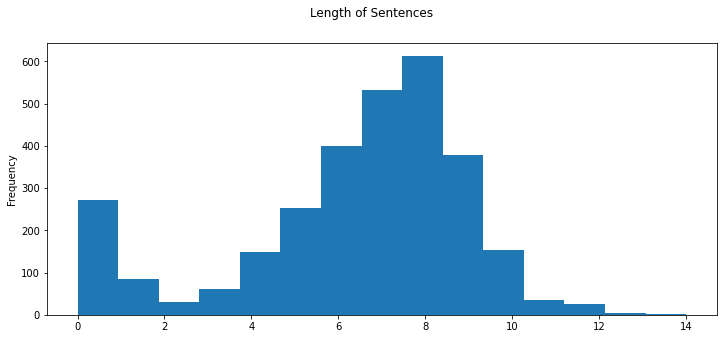

In [7]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Length of Sentences', fontsize=12)
df['len'].plot.hist(bins=15);

In [8]:
df = df[df['len'] > 1].drop_duplicates(subset=['cleaned']).reset_index(drop=True)

In [9]:
y = df.cleaned.values.tolist()

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@^_`{|}~\t\n')
tokenizer.fit_on_texts(y)
mask_token_id = len(tokenizer.word_index)+1
tokenizer.word_index.update({'[mask]': mask_token_id})

In [10]:
def get_masked_input(sequence):
    mask = np.random.randint(low=0, high=len(sequence))
    return [token if i != mask else mask_token_id for i, token in enumerate(sequence)]

In [11]:
VOCAB = len(tokenizer.word_index)
MAX_SEQ_LEN = 15
EMBEDDING_VECTOR_LENGTH = 32
DENSE_DIM = 32
NUM_HEADS = 2
RECURRENT_DROPOUT = 0.5

In [12]:
y = tokenizer.texts_to_sequences(y)
x = [get_masked_input(seq) for seq in y]
x = pad_sequences(x, maxlen=MAX_SEQ_LEN, padding='post')
y = pad_sequences(y, maxlen=MAX_SEQ_LEN, padding='post')
y = keras.utils.to_categorical(y)

x.shape, y.shape

((2632, 15), (2632, 15, 3460))

# Model

In [13]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = L.Embedding(input_dim, output_dim)
        self.position_embeddings = L.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config
    
class TransformerEncoder(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config    

2021-12-24 17:15:10.783905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 17:15:10.877396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 17:15:10.878142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 17:15:10.879308: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
positional_embedding (Positi (None, None, 32)          111200    
_________________________________________________________________
transformer_encoder (Transfo (None, None, 32)          10656     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 3460)        114180    
Total params: 236,036
Trainable params: 236,036
Non-trainable params: 0
_________________________________________________________________


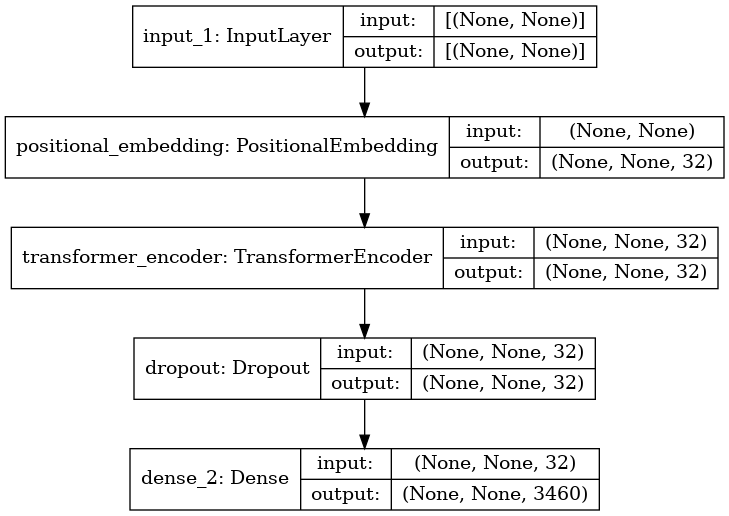

In [14]:
model = keras.Sequential([
    keras.Input(shape=(None, ), dtype="int64"),
    PositionalEmbedding(MAX_SEQ_LEN, VOCAB, EMBEDDING_VECTOR_LENGTH),
    TransformerEncoder(EMBEDDING_VECTOR_LENGTH, DENSE_DIM, NUM_HEADS),
    L.Dropout(0.5),
    L.Dense(VOCAB, activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

# Training

In [15]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
history = model.fit(x=x, y=y, validation_split=0.1, callbacks=[es, rlp], epochs=100)

2021-12-24 17:15:15.187295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
 7/74 [=>............................] - ETA: 0s - loss: 7.9959 - acc: 0.0479      

2021-12-24 17:15:17.790892: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


74/74 [==============================] - 4s 14ms/step - loss: 6.5439 - acc: 0.4645 - val_loss: 4.9480 - val_acc: 0.5109
Epoch 2/100
74/74 [==============================] - 1s 9ms/step - loss: 3.8937 - acc: 0.5320 - val_loss: 2.9605 - val_acc: 0.5725
Epoch 3/100
74/74 [==============================] - 1s 9ms/step - loss: 2.7955 - acc: 0.5970 - val_loss: 2.4072 - val_acc: 0.6662
Epoch 4/100
74/74 [==============================] - 1s 9ms/step - loss: 2.3703 - acc: 0.6591 - val_loss: 2.0926 - val_acc: 0.7371
Epoch 5/100
74/74 [==============================] - 1s 9ms/step - loss: 2.0914 - acc: 0.6995 - val_loss: 1.8710 - val_acc: 0.7737
Epoch 6/100
74/74 [==============================] - 1s 9ms/step - loss: 1.8913 - acc: 0.7247 - val_loss: 1.7079 - val_acc: 0.8028
Epoch 7/100
74/74 [==============================] - 1s 11ms/step - loss: 1.7339 - acc: 0.7465 - val_loss: 1.5896 - val_acc: 0.8210
Epoch 8/100
74/74 [==============================] - 1s 10ms/step - loss: 1.6063 - acc: 0.764

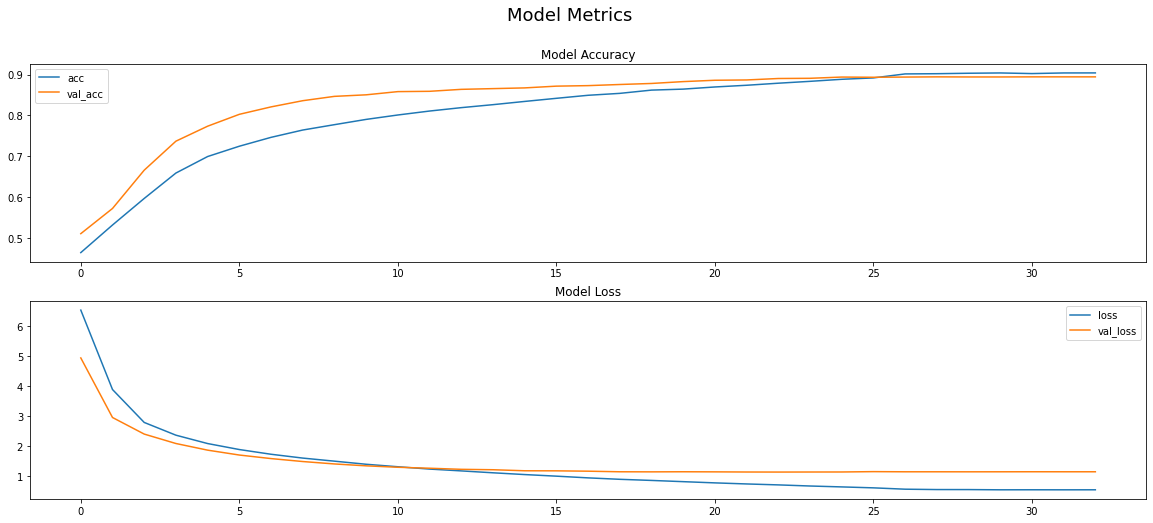

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
metrics = pd.DataFrame(history.history)
metrics[['acc', 'val_acc']].plot(ax=ax[0])
metrics[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

# Inference

In [17]:
query = "to die performing [mask] is no ill;"
query_token_ids = tokenizer.texts_to_sequences([query])
query_token_ids = pad_sequences(query_token_ids, maxlen=MAX_SEQ_LEN, padding='post')

pred = model(query_token_ids)
pred_seq = np.ravel(pred.numpy().argmax(axis=-1))
pred_text = ' '.join(tokenizer.index_word[token] for token in pred_seq if token != 0)
pred_text

'to die adhyatman duty is no ill'